<a href="https://colab.research.google.com/github/NickolasCrema/pyspark_curso/blob/main/pyspark_processamento_de_linguagem_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de processamento de linguagem natural

## Preparando o ambiente

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder\
    .master('local[*]')\
    .appName('Processamento de linguagem natural')\
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Analise exploratoria dos dados

Lendo os dados

In [ ]:
dados = spark.read.csv(
    '/content/drive/MyDrive/data_spark_nlp/imdb-reviews-pt-br.csv',
    escape='\"',
    inferSchema=True,
    header=True
)

Tamanho dos dados

In [ ]:
print(f'N de linhas: {dados.count()} \t N de colunas: {len(dados.columns)}')

N de linhas: 49459 	 N de colunas: 4


Tipo dos dados

In [ ]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



Visualizando dados

In [ ]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



Exemplo de dado negativo e positivo
Tem-se conhecimento que o dado id=190 eh negativo e dado id=12427 eh positivo

In [ ]:
print('Negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)
print('\nPositivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

Contabilizando os tipos de comentario

In [ ]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



## Limpando e processando os dados

In [ ]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



### Gerando WordCloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
amostra = dados.select('text_en').sample(fraction=0.1, seed=101)
all = [text['text_en'] for text in amostra.collect()]

In [ ]:
word_cloud = WordCloud(
    width=1000,
    height=600,
    collocations=False,
    prefer_horizontal = 1
).generate(str(all))

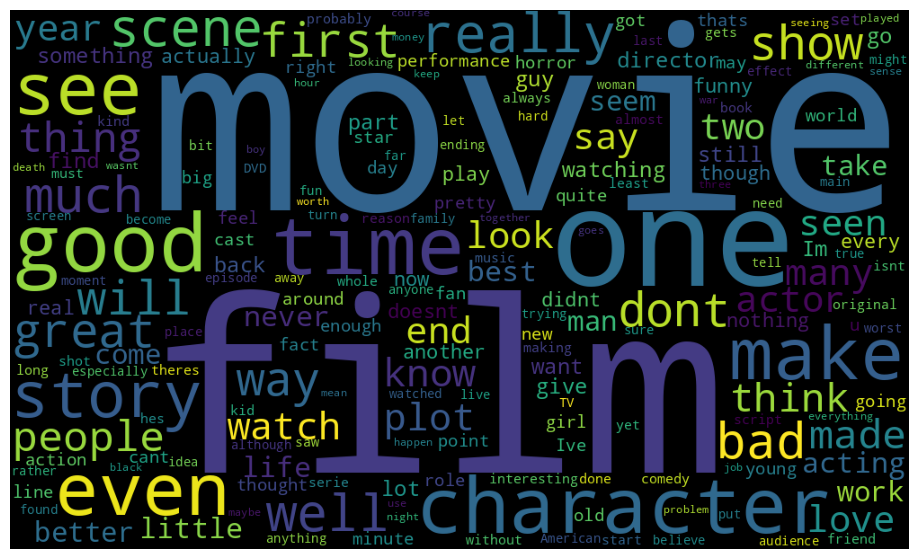

In [ ]:
plt.figure(figsize=(16, 7))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Limpeza dos dados

### Caracteres especiais

In [ ]:
import string
import pyspark.sql.functions as f

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Removendo caracteres especiais

In [ ]:
dados = dados.withColumn("text_en_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

Removendo residuos de espacos em branco

In [ ]:
dados = dados.withColumn("text_en_limpo", f.trim(dados.text_en_regex))

In [ ]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_en_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|A funny thing hap...|A funny thing hap...|
|  7|This German horro...|Este filme de ter...|      neg|This German horro...|This German horro...|


## Tokenizacao

In [ ]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover

In [ ]:
tokenizer = Tokenizer(inputCol = 'text_en_limpo', outputCol = 'tokens')

In [ ]:
tokenizado = tokenizer.transform(dados)

In [ ]:
tokenizado.select('text_en_limpo', 'tokens').show()

+--------------------+--------------------+
|       text_en_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [ ]:
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select('text_en_limpo', 'tokens')\
    .withColumn('freq_tokens', countTokens(f.col('tokens')))\
    .show()

+--------------------+--------------------+-----------+
|       text_en_limpo|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "tokens_final")

In [ ]:
features = remover.transform(tokenizado)

features.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_en_limpo|              tokens|        tokens_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [ ]:
features.select('tokens_final', 'tokens')\
    .withColumn('freq_tokens_final', countTokens(f.col('tokens_final')))\
    .withColumn('freq_tokens', countTokens(f.col('tokens')))\
    .show()

+--------------------+--------------------+-----------------+-----------+
|        tokens_final|              tokens|freq_tokens_final|freq_tokens|
+--------------------+--------------------+-----------------+-----------+
|[mr, costner, dra...|[once, again, mr,...|               73|        168|
|[example, majorit...|[this, is, an, ex...|              131|        232|
|[first, hate, mor...|[first, of, all, ...|              111|        215|
|[even, beatles, w...|[not, even, the, ...|              169|        308|
|[brass, pictures,...|[brass, pictures,...|              140|        238|
|[funny, thing, ha...|[a, funny, thing,...|               52|        115|
|[german, horror, ...|[this, german, ho...|               74|        156|
|[longtime, fan, j...|[being, a, longti...|               73|        136|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|               75|        129|
|[wealthy, horse, ...|[wealthy, horse, ...|               99|        160|
|[cage, plays, dru...|[cage, plays, a,

## Bag of Words

### CountVectorizer

In [ ]:
from pyspark.ml.feature import CountVectorizer

In [ ]:
count_vectorizer = CountVectorizer(inputCol = 'tokens_final', outputCol = 'count_vec')

In [ ]:
model = count_vectorizer.fit(features)
count_vectorizer_features = model.transform(features)

In [ ]:
count_vectorizer_features.select('tokens_final', 'count_vec').limit(10).show()

+--------------------+--------------------+
|        tokens_final|           count_vec|
+--------------------+--------------------+
|[mr, costner, dra...|(221187,[0,7,8,11...|
|[example, majorit...|(221187,[1,2,3,8,...|
|[first, hate, mor...|(221187,[0,2,4,11...|
|[even, beatles, w...|(221187,[0,1,2,4,...|
|[brass, pictures,...|(221187,[1,3,5,8,...|
|[funny, thing, ha...|(221187,[1,2,7,22...|
|[german, horror, ...|(221187,[0,1,2,7,...|
|[longtime, fan, j...|(221187,[0,1,5,8,...|
|[tokyo, eyes, tel...|(221187,[1,4,9,10...|
|[wealthy, horse, ...|(221187,[6,7,10,1...|
+--------------------+--------------------+



In [ ]:
model.vocabulary

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'dont',
 'first',
 'movies',
 'made',
 'make',
 'films',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'best',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'still',
 'say',
 'end',
 'scene',
 'man',
 'scenes',
 'something',
 'go',
 'im',
 'watching',
 'back',
 'real',
 'actors',
 'thing',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'find',
 'nothing',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'part',
 'cant',
 'us',
 'want',
 'pretty',
 'quite',
 'director',
 'thats',
 'cast',
 'things',
 'got',
 'seems',
 'young',
 'around',
 'take',
 'fact',
 'enough',
 'give',
 'big',
 'horror',
 'thought',
 'world',
 'ive',
 'may',
 'saw',
 'however',
 'isnt',
 'always',
 'long',
 'with

### HashingTF : Alternativa para CountVectorizer

In [ ]:
from pyspark.ml.feature import HashingTF

In [ ]:
hashing_tf = HashingTF(inputCol = 'tokens_final', outputCol = 'hashing_tf')

In [ ]:
hashing_tf.setNumFeatures(50)

HashingTF_38a6f923d21f

In [ ]:
htf_featurized_data = hashing_tf.transform(count_vectorizer_features)

In [ ]:
htf_featurized_data.select('tokens_final', 'hashing_tf').limit(10).show()

+--------------------+--------------------+
|        tokens_final|          hashing_tf|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
|[funny, thing, ha...|(50,[0,2,3,7,8,10...|
|[german, horror, ...|(50,[0,2,3,5,7,8,...|
|[longtime, fan, j...|(50,[0,1,3,5,7,10...|
|[tokyo, eyes, tel...|(50,[0,1,3,4,5,8,...|
|[wealthy, horse, ...|(50,[0,1,2,3,5,6,...|
+--------------------+--------------------+



### TF-IDF: ponderando palavras

<img src='https://www.alura.com.br/artigos/assets/guia-nlp-conceitos-tecnicas/calculo-tfidf.png'>

In [ ]:
from pyspark.ml.feature import IDF

In [ ]:
idf = IDF(inputCol = 'hashing_tf', outputCol = 'features')

In [ ]:
idf_model = idf.fit(htf_featurized_data)

In [ ]:
idf_featurized_data = idf_model.transform(htf_featurized_data)

In [ ]:
idf_featurized_data.select('tokens_final', 'features').limit(10).show()

+--------------------+--------------------+
|        tokens_final|            features|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
|[funny, thing, ha...|(50,[0,2,3,7,8,10...|
|[german, horror, ...|(50,[0,2,3,5,7,8,...|
|[longtime, fan, j...|(50,[0,1,3,5,7,10...|
|[tokyo, eyes, tel...|(50,[0,1,3,4,5,8,...|
|[wealthy, horse, ...|(50,[0,1,2,3,5,6,...|
+--------------------+--------------------+



## Codificando target

In [ ]:
idf_featurized_data.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
string_indexer = StringIndexer(inputCol='sentiment', outputCol='label')

In [ ]:
dataset = string_indexer.fit(dados).transform(dados)

In [ ]:
dataset.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



## Utilizando Pipeline

In [ ]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = "text_en_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="tokens_final")

hashing_tf = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

string_indexer = StringIndexer(inputCol='sentiment', outputCol='label')

pipeline = Pipeline(stages = [tokenizer, stopwords, hashing_tf, tfidf, string_indexer])

In [ ]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [ ]:
dados_transformados.select('tokens_final', 'HTF', 'features', 'label').limit(10).show()

+--------------------+--------------------+--------------------+-----+
|        tokens_final|                 HTF|            features|label|
+--------------------+--------------------+--------------------+-----+
|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|  0.0|
|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|  0.0|
|[first, hate, mor...|(1000,[1,7,33,38,...|(1000,[1,7,33,38,...|  0.0|
|[even, beatles, w...|(1000,[0,3,10,12,...|(1000,[0,3,10,12,...|  0.0|
|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|  0.0|
|[funny, thing, ha...|(1000,[0,3,11,38,...|(1000,[0,3,11,38,...|  0.0|
|[german, horror, ...|(1000,[3,29,34,43...|(1000,[3,29,34,43...|  0.0|
|[longtime, fan, j...|(1000,[1,3,12,26,...|(1000,[1,3,12,26,...|  0.0|
|[tokyo, eyes, tel...|(1000,[3,29,48,77...|(1000,[3,29,48,77...|  0.0|
|[wealthy, horse, ...|(1000,[10,18,32,3...|(1000,[10,18,32,3...|  0.0|
+--------------------+--------------------+--------------------+-----+



## Selecionando features

In [ ]:
feature_df = dados_transformados.select('features', 'label')

In [ ]:
feature_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
feature_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+
only showing top 5 rows



### Pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = "text_en_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="tokens_final")

hashing_tf = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

string_indexer = StringIndexer(inputCol='sentiment', outputCol='label')

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashing_tf, tfidf, string_indexer, dt])

## Amostra e treino

In [ ]:
train, test = dados.randomSplit([0.7, 0.3], seed=101)

### Ajustando modelo com o pipeline

In [ ]:
dt_model = pipeline.fit(train)

In [ ]:
predictions = dt_model.transform(test)

In [ ]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_en_limpo|              tokens|        tokens_final|                 HTF|            features|label|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|  1.0| [1108.0,369.0]|[0.75016926201760...|       0.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

### Teste e Métricas

In [ ]:
predictions.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol = 'label', metricName='accuracy')

accuracy = evaluator.evaluate(predictions)

In [ ]:
print(f"Acurácia = {accuracy*100}%")

Acurácia = 67.33468286099865%


### Nova frase

In [ ]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "text_en_limpo"])

In [ ]:
nova_class = dt_model.transform(nova_base)

In [ ]:
nova_class.select('id', 'text_en_limpo', 'prediction').orderBy('id').show(truncate=False)

+---+----------------------------------------------------------------------------------------+----------+
|id |text_en_limpo                                                                           |prediction|
+---+----------------------------------------------------------------------------------------+----------+
|0  |I loved the movie, excellent acting!                                                    |0.0       |
|1  |This is without doubt the worst movie i have ever seen, I hated the acting of the actor.|1.0       |
+---+----------------------------------------------------------------------------------------+----------+

